# IMPORTING NECESSEARY LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split


In [6]:
df= pd.read_excel("/Users/hanishka_kela/Documents/Healthcare_Premium_Prediction_(Regression)/Data_resources/premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [7]:
df.shape

(50000, 13)

# DATA CLEANING


In [13]:
df.columns=df.columns.str.replace(' ','_').str.lower()

In [14]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [15]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

# HANDLE NA VALUES

In [16]:
df.dropna(inplace=True)

In [17]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

# CHECKING FOR DUPLICATES

In [21]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [22]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [25]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [27]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [55]:
numeric_coloumns = df.select_dtypes(include='number').columns
numeric_coloumns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

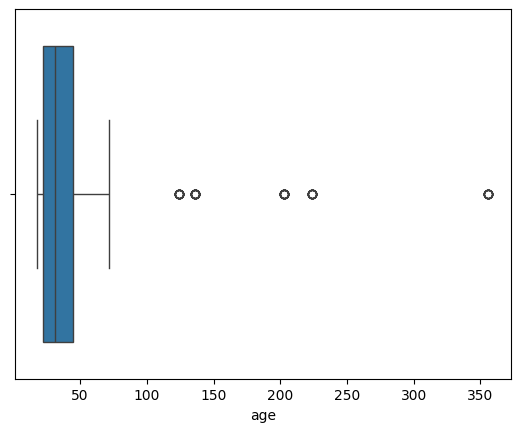

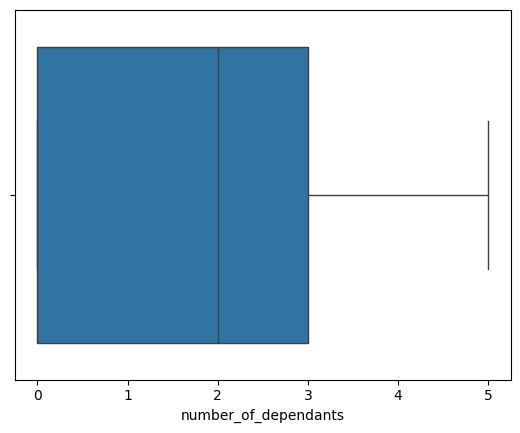

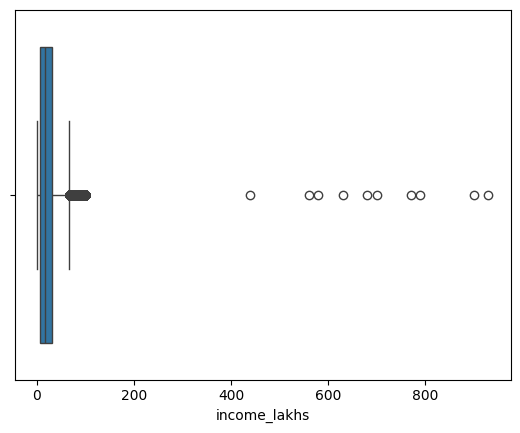

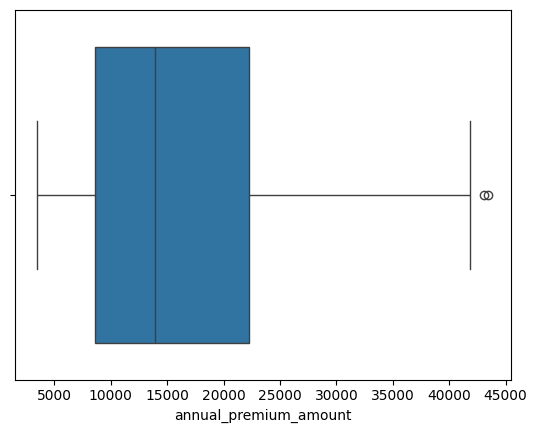

In [56]:
for col in numeric_coloumns:
    sns.boxplot(x=df[col])
    plt.show()

In [57]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [58]:
df1=df[df.age<=100].copy()
df1.describe()


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [59]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound

get_iqr_bounds(df1.income_lakhs)


(-29.0, 67.0)

In [60]:
qunatile_threshold= df1.income_lakhs.quantile(0.999)
qunatile_threshold

np.float64(100.0)

In [61]:
df2 = df1[df1.income_lakhs<=qunatile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


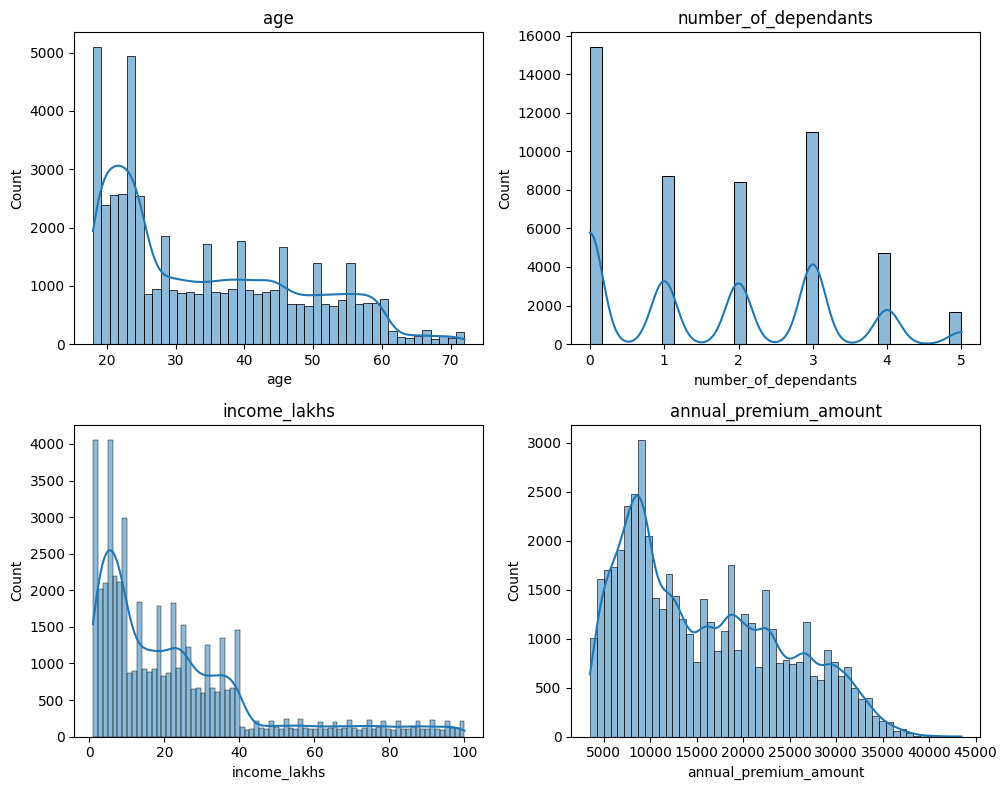

In [64]:
fig, axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_coloumns):
    ax=axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

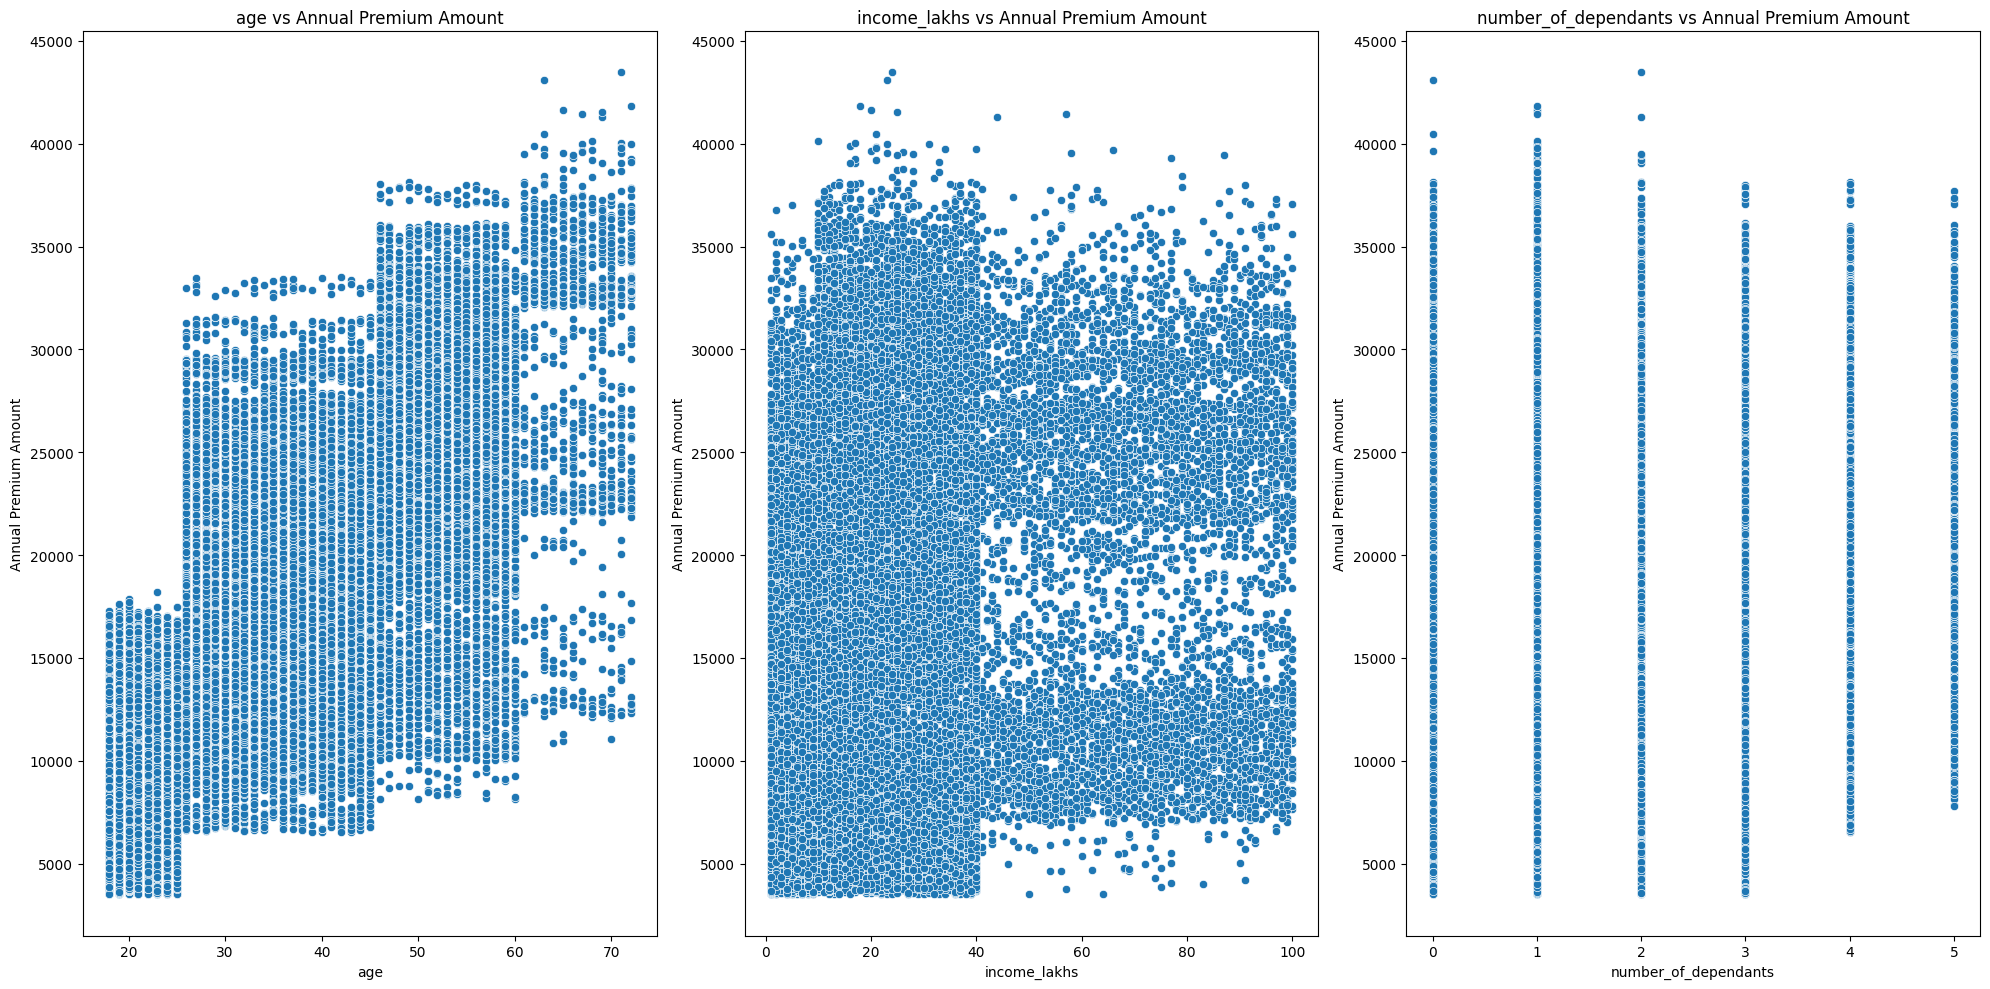

In [73]:
numeric_features=['age','income_lakhs','number_of_dependants']

fig,axes=plt.subplots(1,len(numeric_features),figsize=(20,10))
for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()
plt.show()

In [74]:
categorical_cols=df.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [75]:
for col in categorical_cols:
    print(col,' : ',df2[col].unique() )

gender  :  ['Male' 'Female']
region  :  ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status  :  ['Unmarried' 'Married']
bmi_category  :  ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status  :  ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status  :  ['Salaried' 'Self-Employed' 'Freelancer']
income_level  :  ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history  :  ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan  :  ['Bronze' 'Silver' 'Gold']


In [77]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [79]:
pct_count=df2['gender'].value_counts(normalize=True)

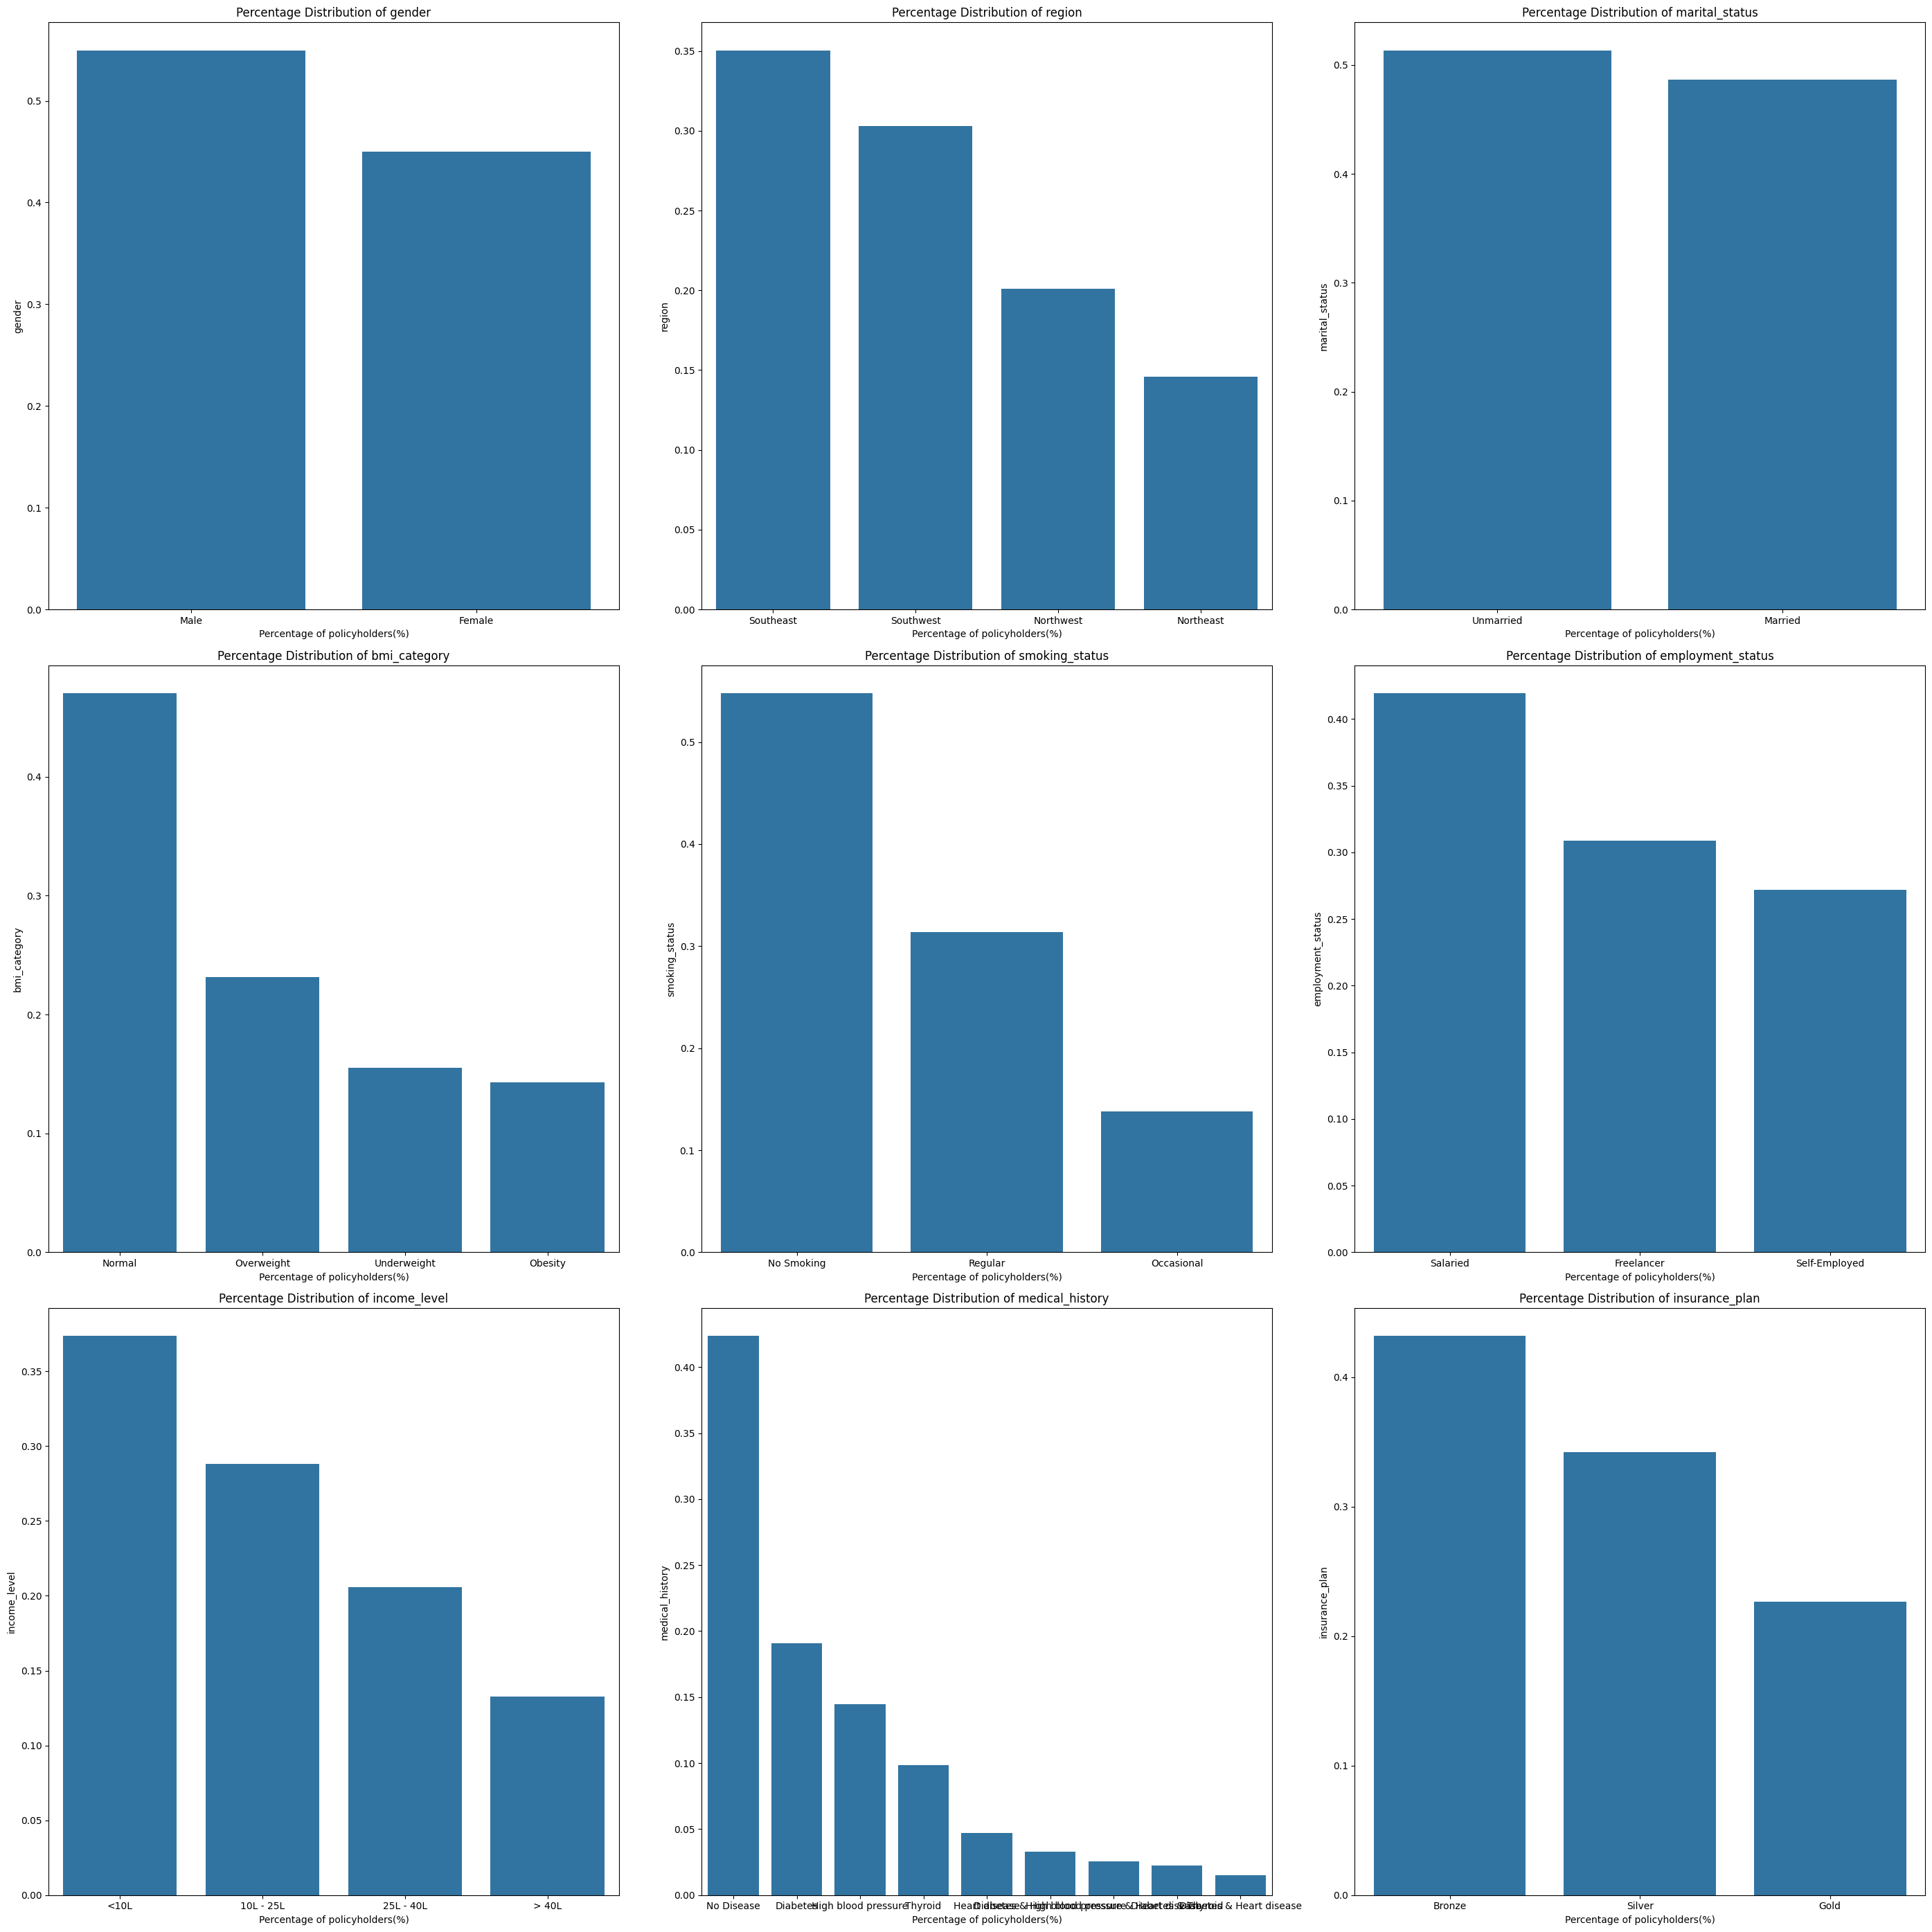

In [82]:
fig, axes=plt.subplots(3,3,figsize=(28,28))
axes=axes.flatten()
for ax, col in zip(axes, categorical_cols):
    category_counts=df2[col].value_counts(normalize=True)
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution of {col}')
    ax.set_xlabel("Percentage of policyholders(%)")
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()    

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


<Axes: xlabel='income_level'>

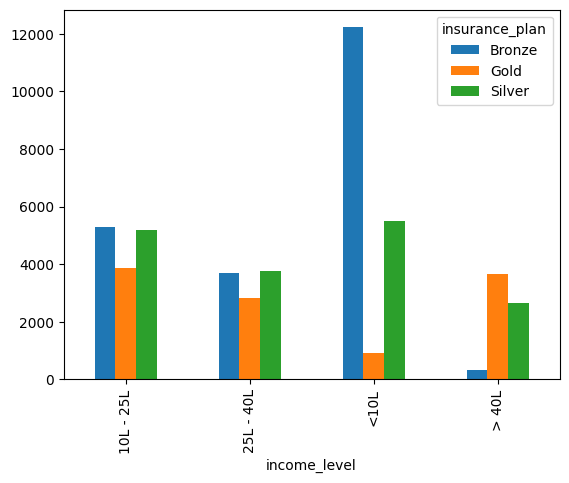

In [85]:
crosstab=pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar')

<Axes: xlabel='insurance_plan', ylabel='income_level'>

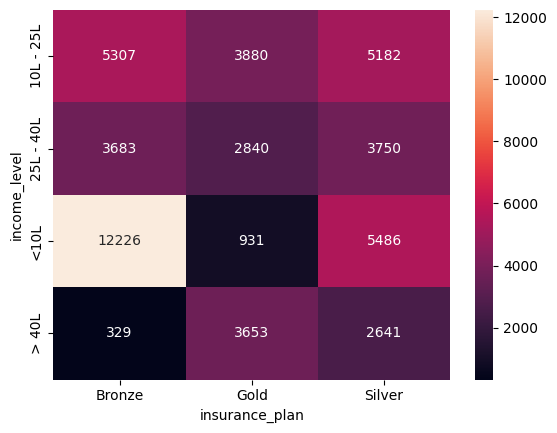

In [86]:
sns.heatmap(crosstab,annot=True,fmt='d')

# FEATURE ENGINEERING 

In [87]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [100]:
risk_scores={
    'diabetes':6,
    'heart disease':8,
    'high blood pressure':6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

df2[['disease1','disease2']]= df2['medical_history'].str.split(' & ',expand =True).apply(lambda x:x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None,NaN,NaN
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None,NaN,NaN
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None,NaN,NaN


In [101]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score']=0

for disease in['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head()

/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/308706082.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace=True)
/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_16974/308706082.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [103]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
29355,19,Female,Northwest,Unmarried,1,Obesity,No Smoking,Salaried,> 40L,54,No Disease,Silver,11769,no disease,none,0,0.000000
784,58,Male,Southeast,Married,4,Overweight,Regular,Freelancer,10L - 25L,16,No Disease,Gold,29466,no disease,none,0,0.000000
28803,31,Female,Northeast,Married,3,Normal,Regular,Salaried,<10L,1,Diabetes,Bronze,12261,diabetes,none,6,0.428571
33948,45,Female,Northwest,Unmarried,0,Normal,Occasional,Salaried,> 40L,47,High blood pressure & Heart disease,Gold,26785,high blood pressure,heart disease,14,1.000000
41864,22,Male,Southeast,Unmarried,0,Normal,No Smoking,Salaried,<10L,8,No Disease,Bronze,7654,no disease,none,0,0.000000
38411,19,Female,Southeast,Unmarried,0,Normal,Regular,Freelancer,10L - 25L,25,No Disease,Bronze,6975,no disease,none,0,0.000000
366,43,Female,Northeast,Married,4,Overweight,Regular,Salaried,<10L,9,Thyroid,Bronze,13976,thyroid,none,5,0.357143
43837,21,Female,Southwest,Unmarried,0,Underweight,No Smoking,Salaried,25L - 40L,26,No Disease,Bronze,7615,no disease,none,0,0.000000
7102,36,Male,Southwest,Married,4,Overweight,No Smoking,Salaried,25L - 40L,29,Thyroid,Silver,17887,thyroid,none,5,0.357143
12324,54,Male,Southeast,Married,3,Obesity,Regular,Self-Employed,10L - 25L,12,High blood pressure,Gold,33445,high blood pressure,none,6,0.428571
